# in this notebook:
### extract km metric for cifar10 by running k-means algorithm on the features
  - get features after running SWaV om cifar10
  - run k-means with different k value and find the best by elbow method

In [1]:
import os
import random
import re
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torchvision
from lightly.data import (
    LightlyDataset,
    collate,
)
import pickle
from scipy.spatial.distance import cdist
from sklearn import neighbors
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from yellowbrick.cluster import KElbowVisualizer

from swav_cifar import SwaVModel
from train import DIR_ROOT_SAVE
from utils import PATH_DATASETS

warnings.filterwarnings("ignore", category=UserWarning)
sns.set(font_scale=1.2)

NUM_TRAIN = 50000
NUM_TEST = 10000
NUM_FEATURES = 512
BATCH_SIZE = 512
NUM_CLASSES = 10
path_to_train = os.path.join(PATH_DATASETS, 'cifar10images', 'train')
path_to_test = os.path.join(PATH_DATASETS, 'cifar10images', 'test')

# No additional augmentations for the test set
test_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=collate.imagenet_normalize["mean"],
            std=collate.imagenet_normalize["std"],
        ),
    ]
)

dataset_train_ssl = LightlyDataset(input_dir=path_to_train)
# we use test transformations for getting the feature for kNN on train data
dataset_train_kNN = LightlyDataset(input_dir=path_to_train, transform=test_transforms)
dataset_test = LightlyDataset(input_dir=path_to_test, transform=test_transforms)

dataloader_train_kNN = torch.utils.data.DataLoader(dataset_train_kNN, batch_size=BATCH_SIZE, shuffle=False,
                                                   drop_last=False, num_workers=4)

dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False, drop_last=False,
                                              num_workers=4)

PATH_MODEL = os.path.join(DIR_ROOT_SAVE, f'swav_cifar10_{NUM_FEATURES}')
swav = SwaVModel(dataloader_train_kNN, NUM_CLASSES)
swav.load_state_dict(torch.load(os.path.join(PATH_MODEL, 'model.pt'))['model'])
swav.eval()

features = np.load(os.path.join(PATH_MODEL, 'feature.npy'))
labels = np.load(os.path.join(PATH_MODEL, 'labels.npy'))
features_test = np.load(os.path.join(PATH_MODEL, 'features_test.npy'))
labels_test = np.load(os.path.join(PATH_MODEL, 'labels_test.npy'))
idx = np.load(os.path.join(PATH_MODEL, 'idx.npy'))

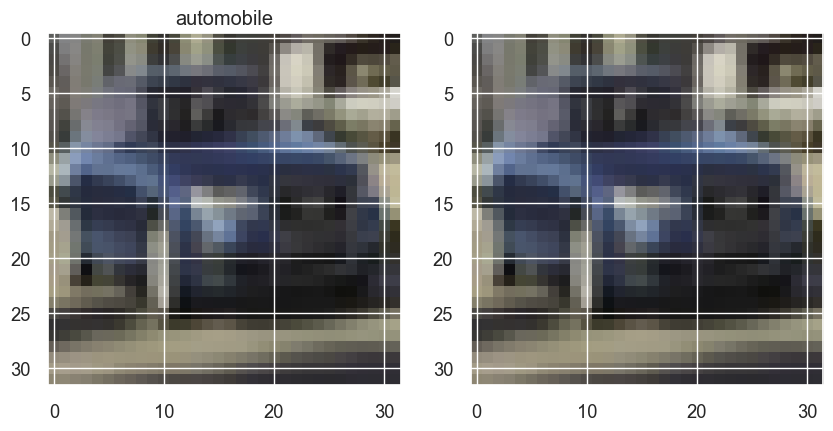

In [2]:
data1 = torchvision.datasets.CIFAR10(PATH_DATASETS, train=True, download=False)
CLASSES = data1.classes
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
i = random.randint(0, NUM_TEST)
img_idx = int(re.findall(r'\d+', dataset_train_ssl[i][2])[-1])
axes[0].set_title(CLASSES[dataset_train_ssl[i][1]])
axes[0].imshow(data1[img_idx][0])
axes[1].imshow(dataset_train_ssl[i][0])
for i in range(NUM_TRAIN):
    img_idx = int(re.findall(r'\d+', dataset_train_ssl[i][2])[-1])
    assert dataset_train_ssl[i][0] == data1[img_idx][0], i

### Projection of 512 dimensions by 2 for check that the feature can separate the classes


In [3]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3, verbose=True).fit_transform(
    features)

df = pd.DataFrame()
df["y"] = labels
df["comp-1"] = X_embedded[:, 0]
df["comp-2"] = X_embedded[:, 1]
df.to_csv(os.path.join(PATH_MODEL, 'tsne.csv'))

[t-SNE] Computing 10 nearest neighbors...
[t-SNE] Indexed 50000 samples in 0.016s...
[t-SNE] Computed neighbors for 50000 samples in 11.482s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50000
[t-SNE] Computed conditional probabilities for sample 2000 / 50000
[t-SNE] Computed conditional probabilities for sample 3000 / 50000
[t-SNE] Computed conditional probabilities for sample 4000 / 50000
[t-SNE] Computed conditional probabilities for sample 5000 / 50000
[t-SNE] Computed conditional probabilities for sample 6000 / 50000
[t-SNE] Computed conditional probabilities for sample 7000 / 50000
[t-SNE] Computed conditional probabilities for sample 8000 / 50000
[t-SNE] Computed conditional probabilities for sample 9000 / 50000
[t-SNE] Computed conditional probabilities for sample 10000 / 50000
[t-SNE] Computed conditional probabilities for sample 11000 / 50000
[t-SNE] Computed conditional probabilities for sample 12000 / 50000
[t-SNE] Computed conditional probabilities for sa

[Text(0.5, 1.0, 'CIFAR10 dataset T-SNE projection')]

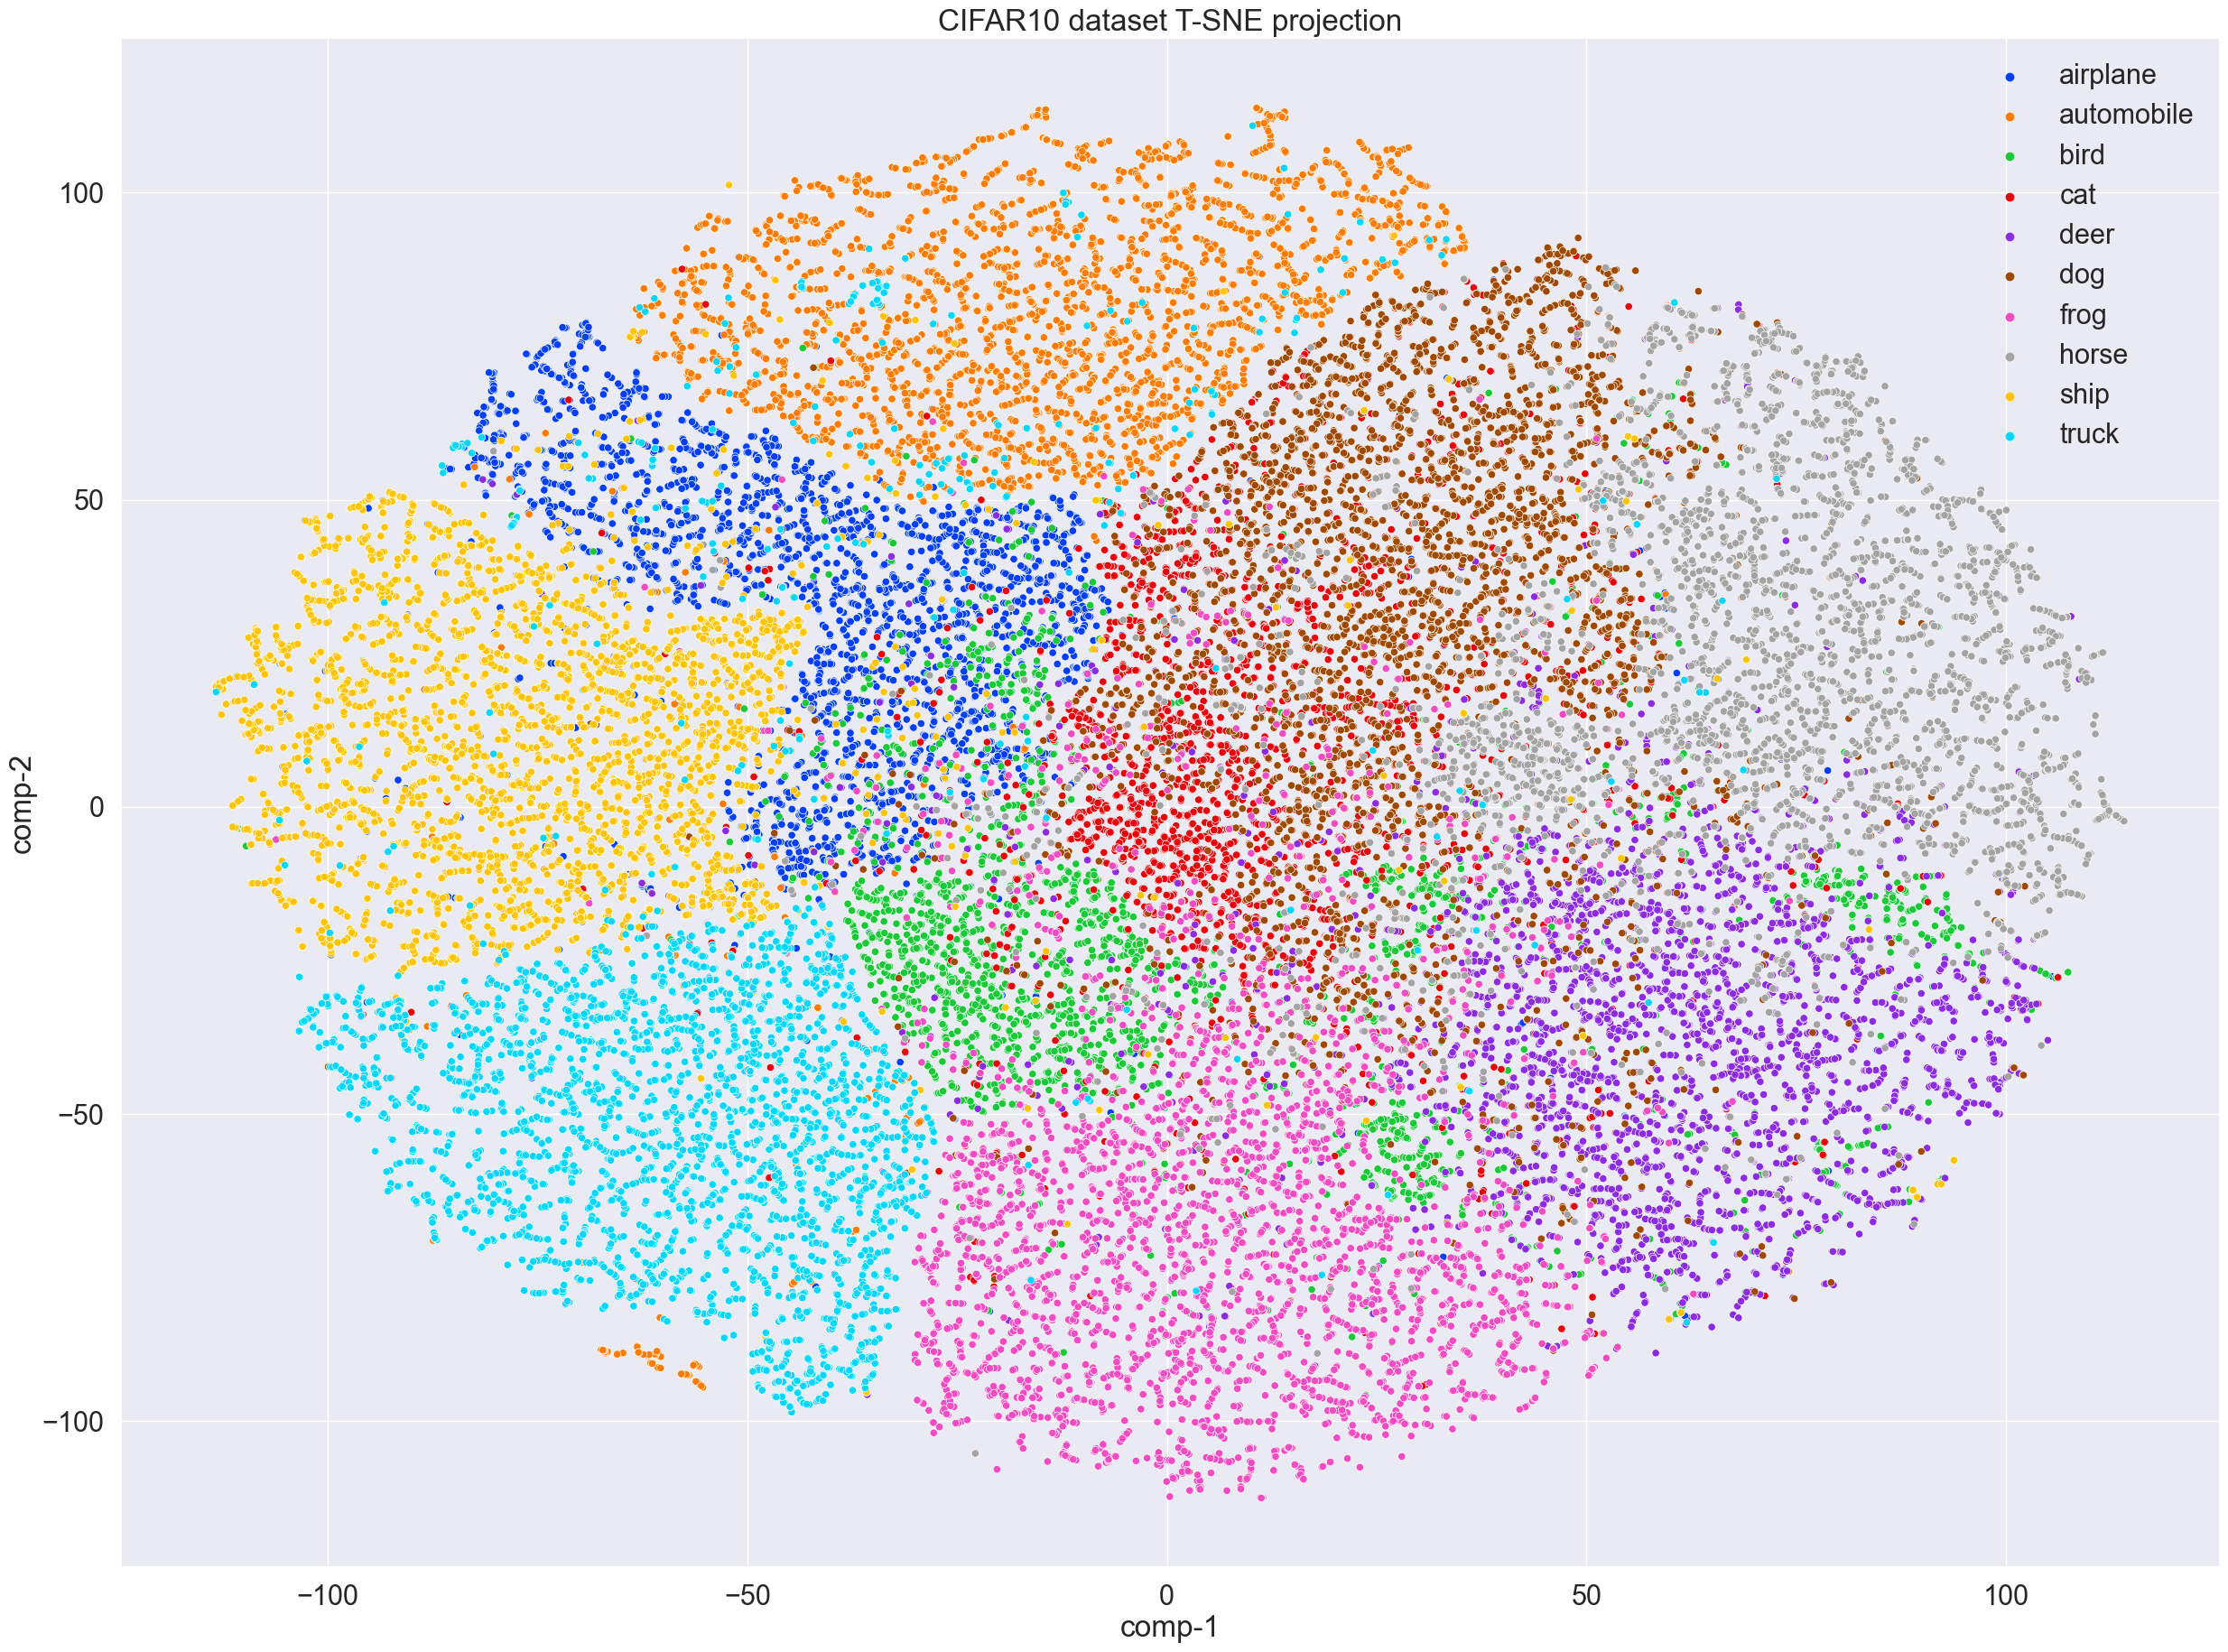

In [4]:
df = pd.read_csv(os.path.join(PATH_MODEL, 'tsne.csv'))
sns.set(rc={'figure.figsize': (30, 22)}, font_scale=2)
sns.scatterplot(x="comp-1", y="comp-2", hue=np.array(CLASSES)[df.y.values],
                palette=sns.color_palette("bright", 10),
                data=df).set(title="CIFAR10 dataset T-SNE projection")

### search the best k for elbow method, we check k in rang 1-301


In [10]:
clf = neighbors.KNeighborsClassifier(n_neighbors=200)
clf.fit(features, labels)
p = clf.predict(features)
sum(np.equal(p, labels)) / NUM_TRAIN

In [11]:
features_test = np.empty((NUM_TEST, NUM_FEATURES))
labels_test = np.empty((NUM_TEST,), dtype=int)

n = 0
for images, label, files_names in dataloader_test:
    features_test[n:n + len(label)] = swav(images).detach().numpy()
    labels_test[n:(n := n + len(label))] = np.array(label)

sum(np.equal(clf.predict(features_test), labels_test)) / NUM_TEST
np.save(os.path.join(PATH_MODEL, 'features_test.npy'), features_test)
np.save(os.path.join(PATH_MODEL, 'labels_test.npy'), labels_test)

In [7]:
idx = np.empty(NUM_TRAIN, dtype=int)
for i, img_data in enumerate(dataset_train_ssl):
    idx[int(re.findall(r'\d+', img_data[2])[-1])] = i
np.save(os.path.join(PATH_MODEL, 'idx.npy'), idx)

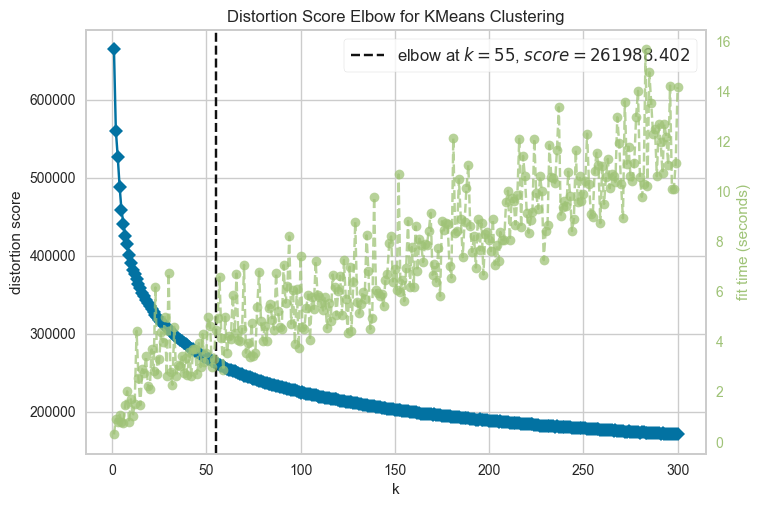

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [92]:
km = KMeans(max_iter=100000, n_init="auto", verbose=True)
visualizer = KElbowVisualizer(km, k=(1, 301))

visualizer.fit(features)  # Fit the data to the visualizer
visualizer.show()

In [ ]:
distortions = {}
inertias = {}
k_val = {}
K = range(1, 301)
for k in K:
    # Building and fitting the model
    print(f'------------   k={k}   --------------------------')
    kMeanModel = KMeans(n_clusters=k, max_iter=100000, n_init="auto", verbose=False).fit(features)

    pred = kMeanModel.predict(features)
    m2 = kMeanModel.transform(features)
    dist_ = m2[np.arange(NUM_TRAIN), pred]
    k_val[k] = dist_

    dist = np.min(cdist(features, kMeanModel.cluster_centers_, 'euclidean'), axis=1)
    distortions[k] = np.average(dist)
    inertias[k] = kMeanModel.inertia_

with open(os.path.join(PATH_MODEL, 'all_k_1_300.npy'), 'wb') as f:
    pickle.dump([k_val, distortions, inertias], f)

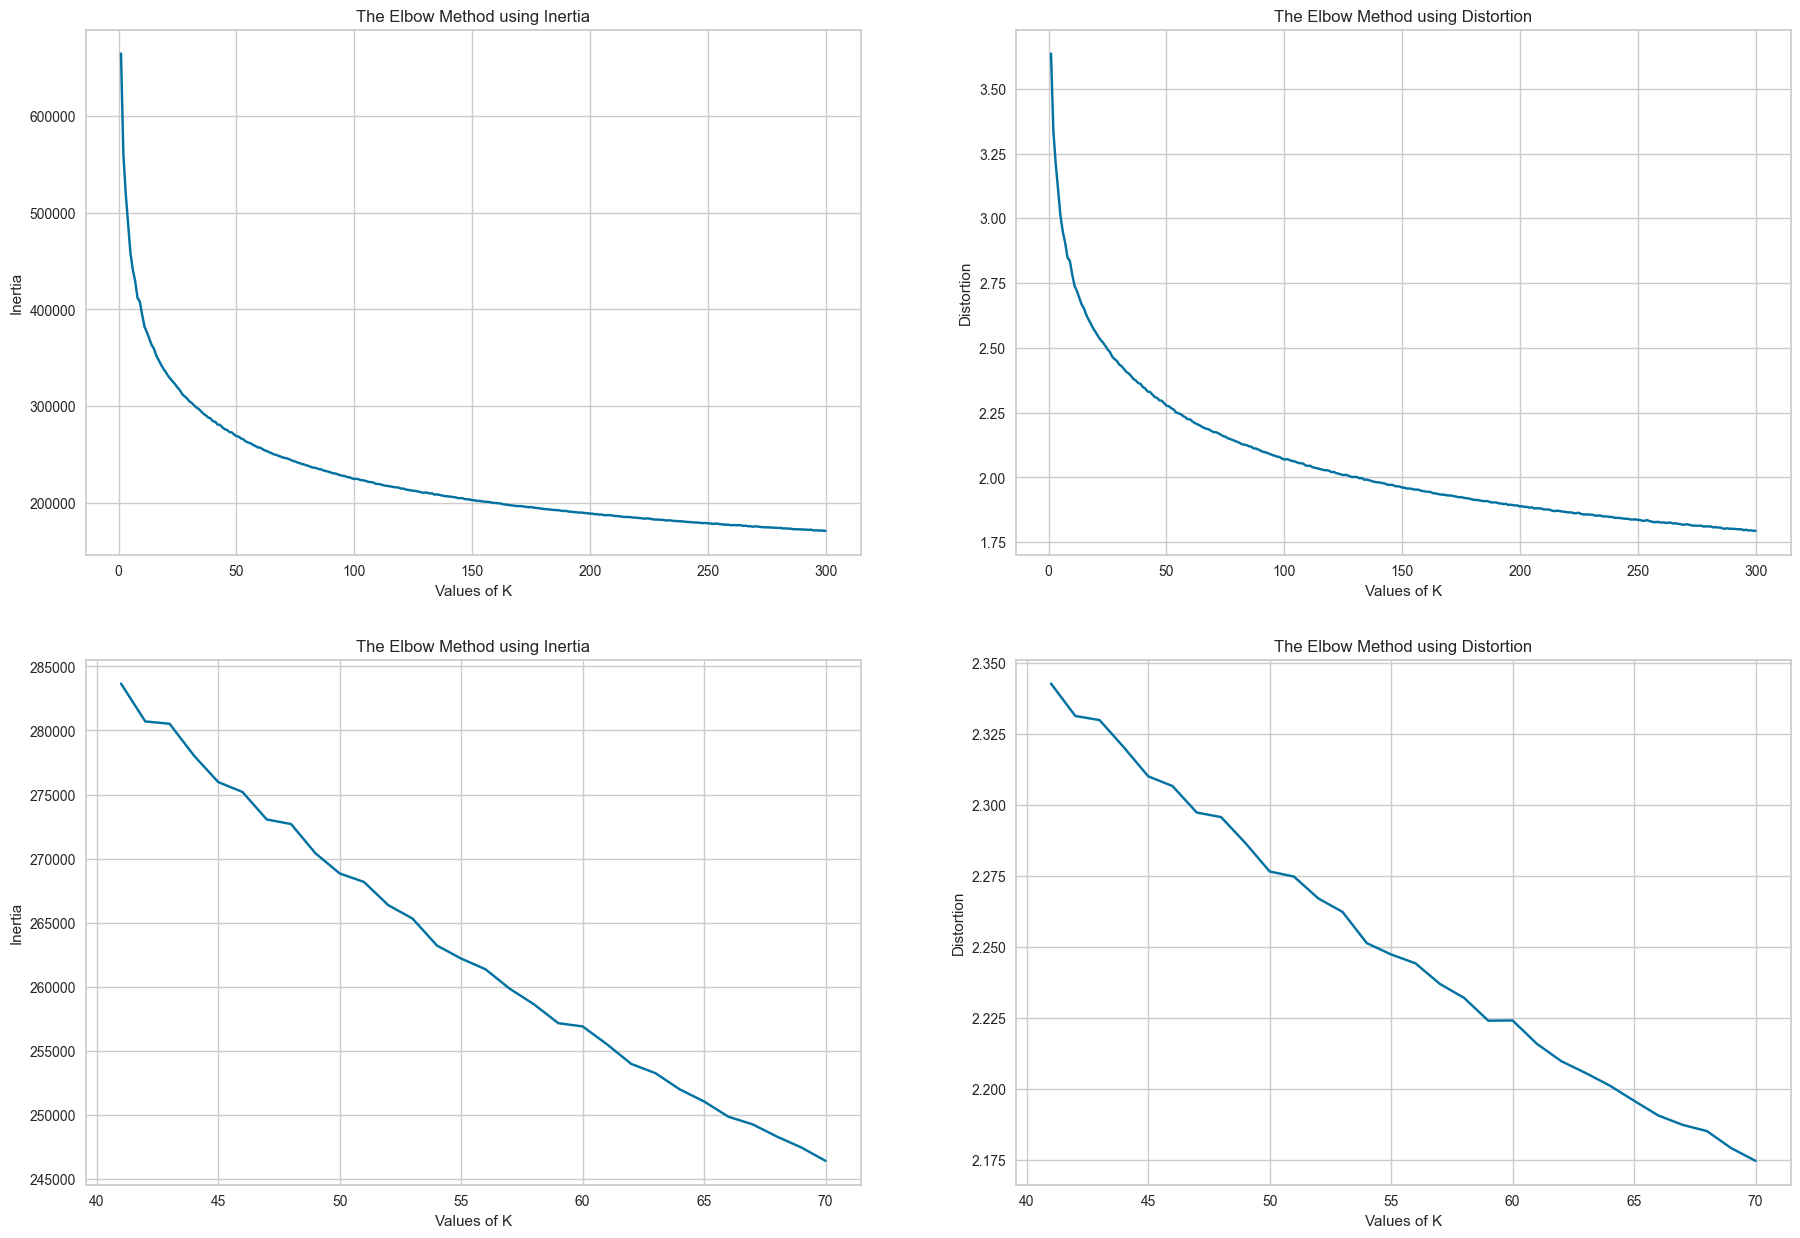

In [23]:
with open(os.path.join(PATH_MODEL, 'all_k_1_300.npy'), 'rb') as f:
    k_val, distortions, inertias = pickle.load(f)

plt.figure(figsize=(22, 15))
plt.subplot(2, 2, 1)
plt.plot([k for k in inertias.keys()], [k for k in inertias.values()], 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')

plt.subplot(2, 2, 2)
plt.plot([k for k in distortions.keys()], [k for k in distortions.values()], 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')

i, j = 40, 70
plt.subplot(2, 2, 3)
plt.plot([k for k in inertias.keys()][i:j], [k for k in inertias.values()][i:j], 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')

plt.subplot(2, 2, 4)
plt.plot([k for k in distortions.keys()][i:j], [k for k in distortions.values()][i:j], 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

### save km metric for k=5,10,55,100,200


In [24]:
k = 55
model_k_55 = KMeans(n_clusters=k, n_init=10, max_iter=100000, verbose=True).fit(features)
pred_55 = model_k_55.predict(features)
m2_55 = model_k_55.transform(features)
km_dist = m2_55[np.arange(NUM_TRAIN), pred_55][idx]
np.save(os.path.join(PATH_MODEL, 'km_dist.npy'), km_dist)

Initialization complete
Iteration 0, inertia 392141.8229316379.
Iteration 1, inertia 279053.0683598094.
Iteration 2, inertia 273393.88698932715.
Iteration 3, inertia 270871.1940606901.
Iteration 4, inertia 269502.55084832327.
Iteration 5, inertia 268642.99383538077.
Iteration 6, inertia 268023.01392290636.
Iteration 7, inertia 267500.55010832875.
Iteration 8, inertia 267038.9460447973.
Iteration 9, inertia 266647.60556278325.
Iteration 10, inertia 266319.28690551664.
Iteration 11, inertia 265999.0105114085.
Iteration 12, inertia 265635.01360086066.
Iteration 13, inertia 265254.04640004935.
Iteration 14, inertia 264909.15736576996.
Iteration 15, inertia 264615.17357549374.
Iteration 16, inertia 264342.1580769138.
Iteration 17, inertia 264103.11910794955.
Iteration 18, inertia 263903.2993966629.
Iteration 19, inertia 263713.5872994664.
Iteration 20, inertia 263549.99762551085.
Iteration 21, inertia 263403.65661940153.
Iteration 22, inertia 263272.51404804515.
Iteration 23, inertia 263169

In [14]:
k = 10
model_k_10 = KMeans(n_clusters=k, n_init=10, max_iter=100000, verbose=True).fit(features)
pred_10 = model_k_10.predict(features)
m2_10 = model_k_10.transform(features)
km_dist_10 = m2_10[np.arange(NUM_TRAIN), pred_10][idx]
np.save(os.path.join(PATH_MODEL, 'km_dist_10.npy'), km_dist_10)

Initialization complete
Iteration 0, inertia 675536.2929688.
Iteration 1, inertia 419908.03493887914.
Iteration 2, inertia 408631.1608064188.
Iteration 3, inertia 403418.8217710983.
Iteration 4, inertia 399187.69670863874.
Iteration 5, inertia 396695.5471509418.
Iteration 6, inertia 395579.7666470923.
Iteration 7, inertia 394812.08498463035.
Iteration 8, inertia 394292.88938091963.
Iteration 9, inertia 393954.9159564172.
Iteration 10, inertia 393736.5571286672.
Iteration 11, inertia 393556.0231622575.
Iteration 12, inertia 393411.6845164232.
Iteration 13, inertia 393277.1369616315.
Iteration 14, inertia 393160.1499050043.
Iteration 15, inertia 393076.73637193965.
Iteration 16, inertia 393008.40793146077.
Iteration 17, inertia 392957.535071928.
Iteration 18, inertia 392920.2542113698.
Iteration 19, inertia 392888.43520808185.
Iteration 20, inertia 392870.27633349394.
Iteration 21, inertia 392858.59332839673.
Iteration 22, inertia 392850.87709994864.
Iteration 23, inertia 392846.26598996

In [15]:
k = 5
model_k_5 = KMeans(n_clusters=k, n_init=10, max_iter=100000, verbose=True).fit(features)
pred_5 = model_k_5.predict(features)
m2_5 = model_k_5.transform(features)
km_dist_5 = m2_5[np.arange(NUM_TRAIN), pred_5][idx]
np.save(os.path.join(PATH_MODEL, 'km_dist_5.npy'), km_dist_5)

Initialization complete
Iteration 0, inertia 846613.3415907067.
Iteration 1, inertia 491846.20924087014.
Iteration 2, inertia 471089.16873871547.
Iteration 3, inertia 461777.75657238736.
Iteration 4, inertia 459497.28460065974.
Iteration 5, inertia 458793.80971600726.
Iteration 6, inertia 458501.67637818336.
Iteration 7, inertia 458382.55657563737.
Iteration 8, inertia 458326.0662002462.
Iteration 9, inertia 458301.1191957973.
Iteration 10, inertia 458289.759671452.
Iteration 11, inertia 458282.5626116085.
Iteration 12, inertia 458279.7400461637.
Iteration 13, inertia 458278.62263635255.
Iteration 14, inertia 458277.9638064513.
Iteration 15, inertia 458277.6411387292.
Iteration 16, inertia 458277.39628490596.
Iteration 17, inertia 458277.1045645628.
Iteration 18, inertia 458277.0137354643.
Iteration 19, inertia 458276.91437861003.
Iteration 20, inertia 458276.81641119305.
Converged at iteration 20: center shift 2.374388688497836e-06 within tolerance 2.5958497822687586e-06.
Initializati

In [16]:
k = 100
model_k_100 = KMeans(n_clusters=k, n_init=10, max_iter=100000, verbose=True).fit(features)
pred_100 = model_k_100.predict(features)
m2_100 = model_k_100.transform(features)
km_dist_100 = m2_100[np.arange(NUM_TRAIN), pred_100][idx]
np.save(os.path.join(PATH_MODEL, 'km_dist_100.npy'), km_dist_100)

Initialization complete
Iteration 0, inertia 330149.57599580305.
Iteration 1, inertia 241387.0590616924.
Iteration 2, inertia 235621.61562626986.
Iteration 3, inertia 233037.7020356107.
Iteration 4, inertia 231494.56682142857.
Iteration 5, inertia 230348.5092611839.
Iteration 6, inertia 229412.7719779289.
Iteration 7, inertia 228687.0527570047.
Iteration 8, inertia 228135.50971195768.
Iteration 9, inertia 227721.54548759008.
Iteration 10, inertia 227409.29246535603.
Iteration 11, inertia 227185.7135092782.
Iteration 12, inertia 226995.79932865652.
Iteration 13, inertia 226842.73980569103.
Iteration 14, inertia 226714.71503093062.
Iteration 15, inertia 226620.30808394303.
Iteration 16, inertia 226537.66630470043.
Iteration 17, inertia 226472.89177183883.
Iteration 18, inertia 226419.24591782258.
Iteration 19, inertia 226371.7892800116.
Iteration 20, inertia 226329.33874896824.
Iteration 21, inertia 226291.0083086024.
Iteration 22, inertia 226252.0002959001.
Iteration 23, inertia 226210.

In [17]:
k = 200
model_k_200 = KMeans(n_clusters=k, n_init=10, max_iter=100000, verbose=True).fit(features)
pred_200 = model_k_200.predict(features)
m2_200 = model_k_200.transform(features)
km_dist_200 = m2_200[np.arange(NUM_TRAIN), pred_200][idx]
np.save(os.path.join(PATH_MODEL, 'km_dist_200.npy'), km_dist_200)

Initialization complete
Iteration 0, inertia 266725.7324925992.
Iteration 1, inertia 201121.82591061993.
Iteration 2, inertia 196557.51122269494.
Iteration 3, inertia 194674.2795872071.
Iteration 4, inertia 193604.006323689.
Iteration 5, inertia 192861.2808419318.
Iteration 6, inertia 192270.40447435263.
Iteration 7, inertia 191813.26949203282.
Iteration 8, inertia 191463.86494984783.
Iteration 9, inertia 191182.10736125513.
Iteration 10, inertia 190934.14454299194.
Iteration 11, inertia 190728.04750232596.
Iteration 12, inertia 190552.01765842445.
Iteration 13, inertia 190403.15883532973.
Iteration 14, inertia 190282.31615967036.
Iteration 15, inertia 190175.8308382063.
Iteration 16, inertia 190084.24904986893.
Iteration 17, inertia 190009.446867682.
Iteration 18, inertia 189942.05027671254.
Iteration 19, inertia 189876.99639005095.
Iteration 20, inertia 189818.98142332604.
Iteration 21, inertia 189768.30334056183.
Iteration 22, inertia 189720.5336534856.
Iteration 23, inertia 189676.

### correlation between km metric and other metrics


In [18]:
PATH_EL2N = os.path.join(DIR_ROOT_SAVE, 'el2n_resnet18_cifar10', 'general.pt')
PATH_FORGET = os.path.join(DIR_ROOT_SAVE, 'flip_cifar10', 'model', 'other.pt')

# get prune scores
data = torch.load(PATH_EL2N)

ensemble_softmax = data['ensemble_softmax']
ensemble_pred = data['ensemble_pred']
ensemble_pred_sum = data['ensemble_pred_sum']
ensemble_std = data['ensemble_std']
el2n_scores = data['el2n_scores']
change_counter = torch.load(PATH_FORGET)['change_counter']
true_forget = torch.load(PATH_FORGET)['true_forget']
km_5 = np.load(os.path.join(PATH_MODEL, 'km_dist_5.npy'))
km_10 = np.load(os.path.join(PATH_MODEL, 'km_dist_10.npy'))
km_55 = np.load(os.path.join(PATH_MODEL, 'km_dist.npy'))
km_100 = np.load(os.path.join(PATH_MODEL, 'km_dist_100.npy'))
km_200 = np.load(os.path.join(PATH_MODEL, 'km_dist_200.npy'))

idx_sorted_el2n = el2n_scores.sort()[1].numpy()
idx_sorted_forgetting = change_counter.sort()[1].numpy()
idx_sorted_std = ensemble_std.sum(dim=1).sort()[1].numpy()
idx_sorted_pred_sum = ensemble_pred_sum.sort()[1].numpy()[::-1]
idx_true_forget = true_forget.sort()[1].numpy()
idx_random_prune = np.random.choice(np.arange(NUM_TRAIN), NUM_TRAIN, replace=False)
idx_sorted_km_5 = np.argsort(km_5)
idx_sorted_km_10 = np.argsort(km_10)
idx_sorted_km_55 = np.argsort(km_55)
idx_sorted_km_100 = np.argsort(km_100)
idx_sorted_km_200 = np.argsort(km_200)

idx_sorted = {'random': idx_random_prune, 'el2n': idx_sorted_el2n, 'std': idx_sorted_std,
              'pred_sum': idx_sorted_pred_sum, 'flip': idx_sorted_forgetting, 'forget': idx_true_forget,
              'km': idx_sorted_km_55}

data = pd.DataFrame({
    'EL2N': el2n_scores.numpy(),
    'Std': ensemble_std.sum(dim=1).numpy(),
    'True p sum': ensemble_pred_sum.numpy(),  # number of models that right on each example
    'flip': change_counter.numpy(),
    'forget': true_forget.numpy(),
    'km5': km_5,
    'km10': km_10,
    'km': km_55,
    'km100': km_100,
    'km200': km_200,

})
data.corr()

EL2N       Std  True p sum      flip    forget       km5  \
EL2N        1.000000  0.780107   -0.944299  0.658627  0.399751  0.328029   
Std         0.780107  1.000000   -0.660269  0.586532  0.377763  0.309604   
True p sum -0.944299 -0.660269    1.000000 -0.627331 -0.350162 -0.284363   
flip        0.658627  0.586532   -0.627331  1.000000  0.770378  0.259929   
forget      0.399751  0.377763   -0.350162  0.770378  1.000000  0.161169   
km5         0.328029  0.309604   -0.284363  0.259929  0.161169  1.000000   
km10        0.471619  0.455924   -0.397917  0.351784  0.223201  0.580492   
km          0.529046  0.496631   -0.460980  0.394874  0.253914  0.417282   
km100       0.508376  0.472651   -0.447110  0.385965  0.250495  0.387067   
km200       0.517344  0.474010   -0.455366  0.396651  0.258186  0.388392   

                km10        km     km100     km200  
EL2N        0.471619  0.529046  0.508376  0.517344  
Std         0.455924  0.496631  0.472651  0.474010  
True p sum -0.397917 -0.460980 -0.447110 -0.455366  
flip        0.351784  0.394874  0.385965  0.396651  
forget      0.223201  0.253914  0.250495  0.258186  
km5         0.580492  0.417282  0.387067  0.388392  
km10        1.000000  0.557792  0.502318  0.488052  
km          0.557792  1.000000  0.803341  0.733060  
km100       0.502318  0.803341  1.000000  0.818507  
km200       0.488052  0.733060  0.818507  1.000000